In [39]:
import os
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.feature import local_binary_pattern
from copy import deepcopy
import random
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import backend as K
from sklearn.model_selection import GridSearchCV
from keras.metrics import Accuracy

from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from scipy.stats import t, entropy
from sklearn.manifold import _t_sne
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
def accuracy(label, labelhat):
    acc = sklearn.metrics.accuracy_score(label, labelhat) * 100

    #print(f"Accuracy : {acc}%")
    return acc

In [41]:
def TRUNK():
    train_datagen = ImageDataGenerator(validation_split=0.15)
    test_datagen = ImageDataGenerator(validation_split=0.15)

    train_data = train_datagen.flow_from_directory(
        r'C:\Users\mhfar\Desktop\Trunk\Data',
        color_mode="rgb",
        batch_size=32,
        class_mode='categorical',
        target_size=(100, 100),
        shuffle=False, 
        seed=42,
        subset='training')

    test_data = train_datagen.flow_from_directory(
        r'C:\Users\mhfar\Desktop\Trunk\Data',
        color_mode="rgb",
        batch_size=32,
        class_mode='categorical',
        target_size=(100, 100),
        shuffle=False, 
        seed=42,
        subset='validation')

    train_x=np.concatenate([train_data.next()[0] for i in range(train_data.__len__())])
    train_y=np.concatenate([train_data.next()[1] for i in range(train_data.__len__())])

    test_x=np.concatenate([test_data.next()[0] for i in range(test_data.__len__())])
    test_y=np.concatenate([test_data.next()[1] for i in range(test_data.__len__())])

    train_y = np.argmax(train_y, axis = 1)
    test_y = np.argmax(test_y, axis = 1)

    return train_x, train_y, test_x, test_y

In [42]:
def NBest(data, label, Num):
    
    chi2selection = SelectKBest(chi2, k=Num)
    newdata = chi2selection.fit_transform(data, label)
    return newdata

In [43]:
def GABOR_Features(img):
    histograms = []
    for theta in range(0, 4):
        theta = deepcopy(theta/4. * np.pi)
        for sigma in (2, 4):
            for lambda_ in np.arange(np.pi / 4, np.pi, np.pi / 4.):
                for gamma in (0.05, 0.5):
                    kernel__ = cv.getGaborKernel((8, 8), sigma, theta, lambda_, gamma, 0, ktype=cv.CV_32F)
                    filtered = cv.filter2D(img, ddepth=4, kernel= kernel__)
                    hist = cv.calcHist([np.float32(filtered)],[0],None,[256],[0,256]).reshape(-1)
                    histograms.append(hist)
    return np.reshape(histograms, (-1))

In [44]:
def LBP_Features(img):
        lbp = local_binary_pattern(img, 16, 8)
        his = np.histogram(lbp.ravel(), bins=200)
        return np.reshape(his[0], (-1))

In [45]:
def LBP_Gabor_Features(data, method):
    featurematrix = []
    for i in range(len(data)):
        img = data[i]
        lbp = LBP_Features(img)
        gab = GABOR_Features(img)
        if method == 'both':
            features = np.append(lbp, gab, axis = 0)
        elif method == 'lbp':
            features = lbp
        elif method == 'gabor':
            features = gab
        featurematrix.append(features)
    return np.array(featurematrix)

In [46]:
def LowFeatures(data, method = 'both'):
    red_data = data[:, :, :, 0]
    green_data = data[:, :, :, 1]
    blue_data = data[:, :, :, 2]

    red_features = LBP_Gabor_Features(red_data, method)
    green_features = LBP_Gabor_Features(green_data, method)
    blue_features = LBP_Gabor_Features(blue_data, method)
    rgb_features = np.append(red_features, green_features, axis = 1)
    rgb_features = np.append(rgb_features, blue_features, axis = 1)
    return rgb_features

In [47]:
def VGG():
    json_file = open(r"C:\Users\mhfar\Desktop\mmhw3\model.json")
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    model.load_weights(r"C:\Users\mhfar\Desktop\mmhw3\model.h5")
    return model

In [48]:
def CNN():
    json_file = open(r"C:\Users\mhfar\Desktop\cnnweights\model.json")
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    model.load_weights(r"C:\Users\mhfar\Desktop\cnnweights\model_v1.h5")
    return model

In [49]:
def CNNFeatures(cnn, data):
    flatten_layer = K.function([cnn.layers[0].input],[cnn.layers[34].output])
    high_features = []
    for i in range(len(data)):
        img = data[i]
        img = np.reshape(img, (1, 100, 100, 3))
        high_features.append(flatten_layer(img))
    return np.squeeze(high_features)

In [50]:
def VGGFeatures(cnn, data):
    flatten_layer = K.function([cnn.layers[0].input],[cnn.layers[20].output])
    high_features = []
    for i in range(len(data)):
        img = data[i]
        img = np.reshape(img, (1, 100, 100, 3))
        high_features.append(flatten_layer(img))
    return np.squeeze(high_features)

In [51]:
def KNN(train_x, train_y, test_x, test_y, neighbours, reduce_features=False, Num = 1000, knnweights = 'distance', showcm=False):
    if (reduce_features):
        train_x = NBest(train_x, train_y, Num)
        test_x = NBest(test_x, test_y, Num)
    clf = KNeighborsClassifier(n_neighbors = neighbours, weights=knnweights)
    clf.fit(train_x, train_y)

    yhat_train = clf.predict(train_x)
    print(f"train acc: {accuracy(yhat_train, train_y)}")
    yhat_test = clf.predict(test_x)
    print(f"test acc: {accuracy(yhat_test, test_y)}")

    if (showcm):

        cm = confusion_matrix(test_y, yhat_test, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
        disp.plot()
        plt.show()


In [52]:
train_x, train_y, test_x, test_y = TRUNK()

Found 341 images belonging to 12 classes.
Found 52 images belonging to 12 classes.


In [67]:
train_x_Low = LowFeatures(train_x, method='lbp')
test_x_Low = LowFeatures(test_x, method='lbp')


train acc: 100.0
test acc: 61.53846153846154


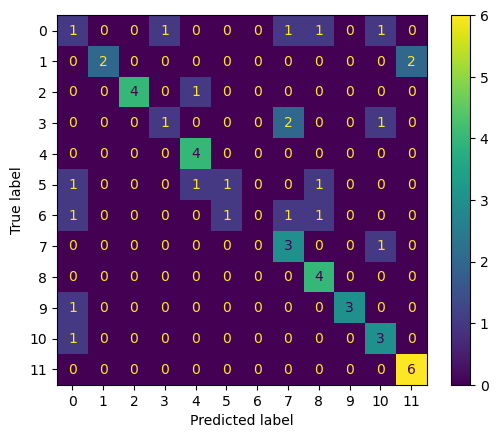

In [68]:
KNN(train_x_Low, train_y, test_x_Low, test_y, neighbours=8, showcm=True)

In [55]:
train_x_Low = LowFeatures(train_x, method='gabor')
test_x_Low = LowFeatures(test_x, method='gabor')


In [56]:
KNN(train_x_Low, train_y, test_x_Low, test_y, neighbours=8)

train acc: 100.0
test acc: 65.38461538461539


In [57]:
train_x_Low = LowFeatures(train_x, method='both')
test_x_Low = LowFeatures(test_x, method='both')


In [58]:
KNN(train_x_Low, train_y, test_x_Low, test_y, neighbours=8)

train acc: 100.0
test acc: 75.0


In [59]:

cnn = CNN()
cnn.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

train_x_High = CNNFeatures(cnn, train_x)
test_x_High = CNNFeatures(cnn, test_x)


In [60]:
"""
cnn = VGG()
cnn.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

train_x_High = VGGFeatures(cnn, train_x)
test_x_High = VGGFeatures(cnn, test_x)
"""

"\ncnn = VGG()\ncnn.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])\n\ntrain_x_High = VGGFeatures(cnn, train_x)\ntest_x_High = VGGFeatures(cnn, test_x)\n"

In [65]:
KNN(train_x_High, train_y, test_x_High, test_y, neighbours=8, reduce_features=False)

train acc: 100.0
test acc: 63.46153846153846


In [62]:
train_x_HighLow = np.append(train_x_High, train_x_Low, axis = 1)
test_x_HighLow = np.append(test_x_High, test_x_Low, axis = 1)

train acc: 100.0
test acc: 75.0


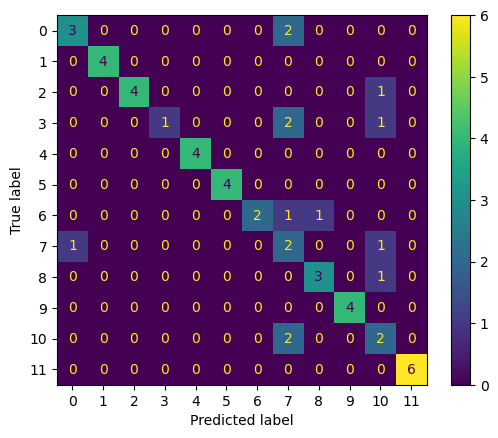

In [63]:
KNN(train_x_HighLow, train_y, test_x_HighLow, test_y, neighbours=8, reduce_features=False, showcm=True)